In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#import important libraries
import numpy as np
import pandas as pd

In [3]:
#train image path definition
image_train = "../input/planets-dataset/planet/planet/train-jpg/"

In [4]:
#dataframes for train label definition
import pandas as pd
train_df = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
#  test image path definition
image_test = "../input/planets-dataset/planet/planet/test-jpg/"

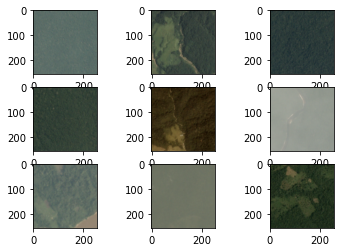

In [6]:
#plot the graph for image_train
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

for i in range(9):
    plt.subplot(330 + 1 + i)
    #filename definition
    filename  = image_train + "train" + "_"  + str(i)  + ".jpg"
    #load image
    img = imread(filename)
    plt.imshow(img)
plt.show()

In [7]:
#read the sample submission
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [8]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission.shape[0] == float(test1[0])+float(test2[0])

In [9]:
test1

['40669']

In [10]:
test2

['20522']

In [11]:
from skimage import io  #read the images as array
#lets see for image 5
image_nos =5
image = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_nos))


In [12]:
#shape of the image
image.shape

(256, 256, 3)

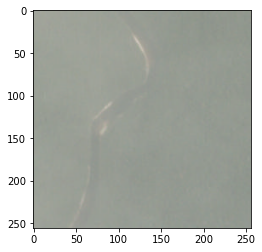

In [13]:
plt.imshow(image)

In [14]:
#extract each tag from train_df
label_list = []
for tag in train_df.tags.values:
    labels = tag.split(" ")# split with empty strings
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [15]:
len(label)

7

In [16]:
len(label_list)

17

In [17]:
#sort the label list
label_list.sort()

In [18]:
#display the label list
label_list

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [19]:
assert len(train_df['image_name'].unique()) == train_df.shape[0]

In [20]:
# let's do one hot encoding (vectorize) the labels in 'train_classes'
for tag in label_list:
    train_df[tag] = train_df['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_df['image_name'] = train_df['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [21]:
%%time

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

y_col = list(train_df.columns[2:]) 

#instatiate  data generator object
datagen = ImageDataGenerator(rescale=1.0/255.0)


# load images from dataframe
X = datagen.flow_from_dataframe(dataframe=train_df, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)


Found 40479 validated image filenames.
CPU times: user 2.57 s, sys: 1.51 s, total: 4.08 s
Wall time: 15.7 s


In [22]:
#using Fbeta consider the evaluation metric
#using a function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten


def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [23]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

#### creating base convnet
****

In [24]:
#create a model function

#instantiate the cnn object
from keras.optimizers import Adam 

def model():
    model = Sequential()
    #add convolution layer
    model.add(Conv2D(32,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform", input_shape =[64,64,3]))
    model.add(Conv2D(32,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))

    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    #add another convolutional layer 2
    model.add(Conv2D(64,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    model.add(Conv2D(64,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    
    
    #add another convolutional layer 3
    model.add(Conv2D(128,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    model.add(Conv2D(128,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    
    #add another convolutional layer 4
    model.add(Conv2D(256,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    model.add(Conv2D(256,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
    #add pooling layer
    model.add(MaxPooling2D((2,2)))
    
#     #add another convolutional layer 4
#     model.add(Conv2D(512,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
#     model.add(Conv2D(512,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
#     #model.add(Dropout(0.25))
#     #add pooling layer
#     model.add(MaxPooling2D((2,2)))
    
#     #add another convolutional layer 4
#     model.add(Conv2D(1024,(3,3),activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
#     model.add(Conv2D(1024,(3,3), activation ="relu",padding = "same",kernel_initializer ="he_uniform"))
#     #model.add(Dropout(0.25))
#     #add pooling layer
#     model.add(MaxPooling2D((2,2)))
    
    
 
    #add a flattening layer
    model.add(Flatten())
    #add a fully connected layer
    model.add(Dense(128,activation ="relu",kernel_initializer="he_uniform"))
    model.add(Dense(17,activation ="sigmoid"))
    optimizer = Adam()
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics =[fbeta])

    return model
    

In [25]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [26]:
generator = ImageDataGenerator(rescale=1/255,validation_split=0.2,shear_range= 0.2,zoom_range= 0.2,horizontal_flip=True)

# generating the 80% training image data
train_gen = generator.flow_from_dataframe(dataframe=train_df, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(64, 64), class_mode='raw', seed=0, batch_size=64, subset='training')

# generating the 20% validation image data
val_gen = generator.flow_from_dataframe(dataframe=train_df, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(64, 64), class_mode='raw', seed=0, batch_size=64, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [27]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [28]:
step_train_size+step_train_size

1012

In [29]:
# fit the model  

# turn on GPU
model1 = model() # building a sequential model for training

In [30]:
# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=15, callbacks=[save_best_check_point])

Epoch 1/15
506/506 [==============================] - 196s 388ms/step - loss: 0.2018 - fbeta: 0.7141 - val_loss: 0.1644 - val_fbeta: 0.7881
Epoch 2/15
506/506 [==============================] - 142s 281ms/step - loss: 0.1540 - fbeta: 0.7969 - val_loss: 0.1411 - val_fbeta: 0.8273
Epoch 3/15
506/506 [==============================] - 138s 272ms/step - loss: 0.1422 - fbeta: 0.8164 - val_loss: 0.1371 - val_fbeta: 0.8157
Epoch 4/15
506/506 [==============================] - 137s 271ms/step - loss: 0.1358 - fbeta: 0.8272 - val_loss: 0.1304 - val_fbeta: 0.8372
Epoch 5/15
506/506 [==============================] - 136s 269ms/step - loss: 0.1304 - fbeta: 0.8376 - val_loss: 0.1259 - val_fbeta: 0.8458
Epoch 6/15
506/506 [==============================] - 136s 269ms/step - loss: 0.1249 - fbeta: 0.8462 - val_loss: 0.1253 - val_fbeta: 0.8542
Epoch 7/15
506/506 [==============================] - 135s 266ms/step - loss: 0.1207 - fbeta: 0.8530 - val_loss: 0.1209 - val_fbeta: 0.8689
Epoch 8/15
506/506 [

In [31]:
model2 = model() # building a sequential model for testing

#loading in the weights of the trained model
model2.load_weights('best_model.hdf5') 

In [32]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [33]:
 # image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [34]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
import tensorflow as tf
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_generator.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=64, shuffle=False, class_mode=None, target_size=(64, 64))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [35]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

636/636 [==============================] - 114s 180ms/step


In [36]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(label_list)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,agriculture clear primary
4,test_4.jpg,partly_cloudy primary


In [40]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [41]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=64, shuffle=False, class_mode=None, target_size=(64, 64))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [42]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

321/321 [==============================] - 69s 216ms/step


In [43]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(label_list)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,agriculture clear partly_cloudy primary road
2,file_10.jpg,haze primary water
3,file_100.jpg,agriculture clear primary
4,file_1000.jpg,clear primary


In [44]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,agriculture clear primary
4,test_4.jpg,partly_cloudy primary


In [45]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [46]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear primary
4,test_4,partly_cloudy primary


In [47]:
final_result.to_csv('final_submission_dense1.csv', index=False) # saving the predictions